1. 2d rgb에서 yolo 진행
2. Depth에 yolo에서 얻은 ROI 적용
3. Camera intrinsic Load
4. ROI depth -> 3d PCD 진행 
5. 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행 
6. PCA 수행하여 주요 축 추출
7. 법선과 PCA축을 통해 좌표계 구성
8. 회전행렬을 통해 RPY변환

이 depth map은 단위: mm, **형식: 16-bit 정수형 (uint16)**입니다.

값이 327 ~ 1513 사이인 것으로 보아, 약 0.3 ~ 1.5미터 범위의 거리 데이터가 포함되어 있어요.

즉, Open3D에서 사용하는 depth_scale=1000.0 설정이 정확히 맞습니다.



In [2]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [95]:
mc.get_coords()

[49.5, -64.6, 410.5, -90.26, 0.26, -90.0]

In [103]:
# image 캡처 
import pyrealsense2 as rs
from datetime import datetime
    
def capture_d455_images(save_dir="/home/ros/llm_robot/data/captures",
                        rgb_size=(848,480), depth_size=(848,480),
                        depth_preset=rs.rs400_visual_preset.high_density):

    """
    • RealSense D455에서 RGB + Depth를 동시에 캡처해 저장
    • save_dir        : 저장 폴더 (없으면 자동 생성)
    • rgb_size        : (w, h)  예) (1280, 720)
    • depth_size      : (w, h)  예) (848, 480)
    • depth_preset    : rs.rs400_visual_preset.*  (기본 High-Accuracy)
    반환값: (color_path, depth_path)
    """
        
    os.makedirs(save_dir, exist_ok=True)

    # 날짜 기반 파일명 생성
    stamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    color_path = os.path.join(save_dir, f"{stamp}_color.jpg")
    depth_path = os.path.join(save_dir, f"{stamp}_depth.npy")

    # RealSense 파이프라인 설정
    pipe, cfg = rs.pipeline(), rs.config()

    cfg.enable_stream(rs.stream.color,  *rgb_size,   rs.format.bgr8, 30)
    cfg.enable_stream(rs.stream.depth,  *depth_size, rs.format.z16,  30)
    profile = pipe.start(cfg)
    
    # intel에서 미리 설정해둔 프리셋인 'High Accuracy' 적용
    depth_sensor = profile.get_device().first_depth_sensor()
    if depth_sensor.supports(rs.option.visual_preset):
        depth_sensor.set_option(rs.option.visual_preset, depth_preset)
    
    # Depthmap 정렬
    frames = rs.align(rs.stream.color).process(pipe.wait_for_frames())
    depth, color = frames.get_depth_frame(), frames.get_color_frame()
    if not depth or not color:
        pipe.stop()
        raise RuntimeError("Failed to capture frames")    
    
    # 저장 (RGB = JPEG, Depth = NPY)
    color_img = np.asanyarray(color.get_data())            # uint8 (BGR)
    depth_raw = np.asanyarray(depth.get_data())            # uint16 (mm / depth_scale)

    cv2.imwrite(color_path, color_img, [cv2.IMWRITE_JPEG_QUALITY, 95])
    np.save(depth_path, depth_raw)

    pipe.stop()
    
    return color_path, depth_path    


### 1. 2D RGB에서 YOLO 수행하여 ROI 가져오기

In [4]:
MAIN_PATH = "/home/ros/llm_robot/"
MODEL_DIR = MAIN_PATH + "yolo11_seg_cube_best.pt"

model = YOLO(MODEL_DIR)

In [105]:
color_path, depth_path = capture_d455_images()

# color_path = "/home/ros/llm_robot/data/captures/2025-07-21_21-09-27_color.jpg"
# depth_path = "/home/ros/llm_robot/data/captures/2025-07-21_21-09-27_depth.npy"

img = cv2.imread(color_path)

result = model(img)


0: 384x640 1 cube, 23.8ms
Speed: 21.5ms preprocess, 23.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


In [106]:
result[0].show()

In [107]:
# yolo 결과 이미지
yolo_img = result[0]

# bbox 추출 (yolo 수행 시 pytorch tensor 형식이 GPU 상에 올라가 있는 경우가 많기 때문에, cpu로 옮겨줌.)
boxes = yolo_img.boxes[0].xyxy.cpu().numpy().astype(int)  

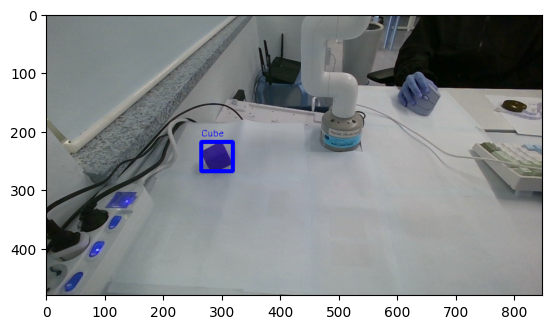

In [108]:
for i, (x1, y1, x2, y2) in enumerate(boxes):
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)
    cv2.putText(img, f'Cube', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
plt.imshow(img);

In [109]:
x1, y1, x2, y2 = boxes[0]
print(x1, y1, x2, y2)

265 218 319 268


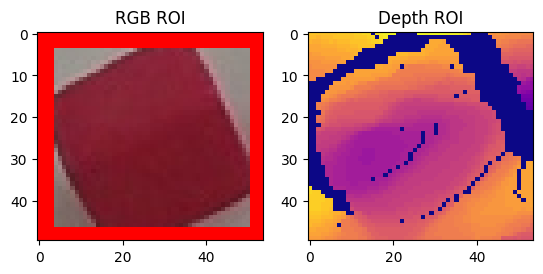

In [110]:
# RGB와 Depth 둘 다 crop해서 시각화 비교
depth = np.load(depth_path)
roi_rgb = img[y1:y2, x1:x2] 
roi_depth = depth[y1:y2, x1:x2]
# roi_depth = np.nan_to_num(roi_depth, nan=0.0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB ROI")

plt.subplot(1, 2, 2)
plt.imshow(roi_depth*1000,cmap="plasma")
plt.title("Depth ROI")
plt.show()


In [111]:
print("RGB shape:", img.shape)     # 예: (480, 640, 3)
print("Depth shape:", depth.shape) # 예: (480, 640)


RGB shape: (480, 848, 3)
Depth shape: (480, 848)


## 3. camera intrinsic load

In [112]:
# camera_intrinsic 불러오기
INTR_DIR = MAIN_PATH + "data/Calibration/d455_intrinsics.yaml"

fs = cv2.FileStorage(INTR_DIR, cv2.FILE_STORAGE_READ)
camera_matrix = fs.getNode("camera_matrix").mat()
dist_coeffs = fs.getNode("dist_coeffs").mat()       # RGB 왜곡 보정용
fs.release()

print(camera_matrix)
print(dist_coeffs)

[[     425.95           0      427.19]
 [          0      425.37         246]
 [          0           0           1]]
[[  -0.055946    0.068781 -0.00011233  0.00074334   -0.022006]]


In [113]:
fx = camera_matrix[0][0]    # 수평 초점 거리
fy = camera_matrix[1][1]    # 수직 초점 거리
ppx = camera_matrix[0][2]    # center x
ppy = camera_matrix[1][2]    # center y

print(fx, fy, ppx, ppy)

425.9524841308594 425.373291015625 427.1853942871094 245.99588012695312


In [114]:
depth.shape[1], depth.shape[0]

(848, 480)

In [115]:
roi_ppx = ppx - x1
roi_ppy = ppy - y1

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=depth.shape[1],
    height=depth.shape[0],
    fx=fx,
    fy=fy,
    cx=ppx,
    cy=ppy
)

roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=roi_depth.shape[1],
    height=roi_depth.shape[0],
    fx=fx,
    fy=fy,
    cx=roi_ppx,
    cy=roi_ppy
)

## 4. ROI Depth -> PointCloud

In [116]:
fx, fy, ppx, ppy 

(425.9524841308594, 425.373291015625, 427.1853942871094, 245.99588012695312)

In [117]:
depth_contig = np.ascontiguousarray(roi_depth)
depth_o3d = o3d.geometry.Image(depth_contig)

# depth_o3d = o3d.geometry.Image(roi_depth)

dummy_gray = np.ones_like(roi_depth, dtype=np.uint8) * 128
dummy_rgb = np.stack([dummy_gray]*3, axis=2) 
dummy_color = o3d.geometry.Image(dummy_rgb)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    dummy_color,
    depth_o3d,
    depth_scale=1000,
    depth_trunc = 2.0,
    convert_rgb_to_intensity = False
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    roi_intrinsic
)

# 좌표계 맞춤 (Open3D 시각화 기준)
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# 시각화
o3d.visualization.draw_geometries([pcd])


# 5. 각 포인트에 대해 Surface Normal 추정

In [118]:
# 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행
pcd.estimate_normals(search_param = o3d.geometry.KDTreeSearchParamKNN(knn=30))
pcd.normalize_normals()

PointCloud with 2161 points.

In [119]:
o3d.visualization.draw_geometries(
    [pcd],
    window_name="Step 3: PCD + Surface Normals",
    point_show_normal=True
)

# 6. PCA 진행하여 주요 축 추출

In [120]:
# 3d 좌표 기준 PCA 수행
points = np.asarray(pcd.points)
center_xyz = np.mean(points, axis=0)
cam_xyz2 = center_xyz.tolist()

# 각 포인트에서 중심 좌표를 빼서 원점으로 재배치
points_centered = points - center_xyz

# 공분산행렬 계산
cov = np.cov(points_centered.T)

# eig_vals: 각 축 방향의 분산 크기 (PCA의 세 개의 주성분 값)
# eig_vecs: 각 열이 고유벡터 → 데이터 분산 방향 벡터
eig_vals, eig_vecs = np.linalg.eigh(cov)

In [121]:
center_xyz

array([    -0.1598,   0.0021956,    -0.49869])

In [122]:
# --- 축 시각화용 line 생성 ---
def create_axis_line(origin, direction, color, length=0.02):
    pts = [origin, origin + direction * length]
    lines = [[0, 1]]
    ls = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector(lines)
    )
    ls.colors = o3d.utility.Vector3dVector([color])
    return ls

x_line = create_axis_line(center_xyz, eig_vecs[:, 0], [1, 0, 0])  # 빨강
y_line = create_axis_line(center_xyz, eig_vecs[:, 1], [0, 1, 0])  # 초록
z_line = create_axis_line(center_xyz, eig_vecs[:, 2], [0, 0, 1])  # 파랑

# --- 6. 시각화 ---
o3d.visualization.draw_plotly([pcd, x_line, y_line, z_line], window_name="PCA Axes")

In [123]:
# 고유값 기준 내림차순 정렬
idx = np.argsort(eig_vals)[::-1]
eig_vecs = eig_vecs[:, idx]  # ← 각 열이 고유벡터 (x, y, z축 순서)

# 축 구성
x_axis = eig_vecs[:, 0]  # 가장 큰 분산 방향 → grasp 방향
y_axis = eig_vecs[:, 1]
z_axis = eig_vecs[:, 2]  # 가장 작은 분산 방향 → surface normal
# print(x_axis, y_axis, z_axis)

# 법선 방향이 아래를 가리키면 반전
if z_axis[2] < 0:
    z_axis = -z_axis
    
# 직교성 확보 (필수!)
x_axis -= np.dot(x_axis, z_axis) * z_axis
x_axis /= np.linalg.norm(x_axis)
y_axis = np.cross(z_axis, x_axis)
print(x_axis, y_axis, z_axis)


[   -0.41374      0.4313    -0.80175] [    -0.9103    -0.20857     0.35757] [  -0.012999     0.87777      0.4789]


# 7. 법선과 PCA 축으로 좌표계 구성

In [124]:
# 4. 회전행렬 구성 (열벡터 기준)
R_mat = np.stack([x_axis, y_axis, z_axis], axis=1)

# 5. Euler angles (RPY) 추출
rpy = Rotation.from_matrix(R_mat).as_euler('xyz', degrees=True)
# rpy_int = rpy.astype(int)
print(f"Roll: {rpy[0]:.2f}, Pitch: {rpy[1]:.2f}, Yaw: {rpy[2]:.2f}")

Roll: 36.75, Pitch: 53.30, Yaw: 133.81


# 실험

In [30]:
import time
from pymycobot import MyCobot280

SERIAL_PORT = "/dev/ttyACM0"
BAUD_RATE = 115200

mc = MyCobot280(SERIAL_PORT, BAUD_RATE)

In [ ]:
# HAND_EYE_PATH = "/home/ros/llm_robot/data/Calibration/cam2gripper.json"

# GRIPPER_OPEN  = 100        # 상황에 맞게 조정
# GRIPPER_CLOSE =   0
# MOVE_SPEED         = 50         # 0~100
# HOVER_Z = 0.05                  # M
# DESCEND_OFFSET = 0.005

In [31]:
def detect_objects(c_path, d_path, target_list, 
                   camera_matrix, dist_coeffs,  
                   best_model = "/home/ros/llm_robot/yolo11x.pt"):
    
    depth_raw  = np.load(d_path)
    depth_scale = 0.001    # mm -> m
    
    # ▶ intrinsics
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    
    model = YOLO(best_model)  
    results = model(c_path)
    
    r = results[0]          # 한 장이니까
    xyxy  = r.boxes.xyxy.cpu().numpy()  # [N,4]
    cls   = r.boxes.cls.cpu().numpy().astype(int)
    conf  = r.boxes.conf.cpu().numpy()
    names = r.names                     # {idx:'label'}

    outputs = []  # 최종 (label, cx, cy, z, x_cam, y_cam, z_cam) 리스트

    for box, c, p in zip(xyxy, cls, conf):
        label = names[c]
        if label not in target_list:        # 🎯 원하는 클래스만 통과
            continue

        x1, y1, x2, y2 = map(int, box)
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Depth ROI → Z (m 기준)
        roi_depth = depth_raw[y1:y2, x1:x2]
        valid = roi_depth[roi_depth > 0]
        if valid.size == 0:
            print(f"[WARN] {label} depth invalid, skip")
            continue
        
        # 평균에서 최소값(평면)을 뺀 값
        # z_floor = np.percentile(valid, 95)  # 바닥 추정
        # z_obj   = np.percentile(valid, 30)  # 물체 추정
        # z = (z_floor - z_obj) * depth_scale 
        z = np.median(valid) * depth_scale 
        
        # 픽셀 좌표 보정
        pixel = np.array([[[center_x, center_y]]], dtype=np.float32)    # (1, 1, 2)
        undistorted = cv2.undistortPoints(pixel, camera_matrix, dist_coeffs)
        cx_u, cy_u = undistorted[0][0]
        
        
        # 픽셀 → 카메라 XYZ 
        x_cam = (cx_u - cx) * z / fx
        y_cam = (cy_u - cy) * z / fy
        z_cam = z

        outputs.append(
            {"label": label,
            "bbox": [x1, y1, x2, y2],
            "pixel_xy": [cx, cy],
            "undistroted_xy": [float(cx_u), float(cy_u)], 
            "depth_m": z,
            "cam_xyz": [x_cam, y_cam, z_cam],
            "conf": float(p)}
        )

    print("\n📦 추출된 객체 정보")
    for obj in outputs:
        print(f"{obj['label']:10s}  z={obj['depth_m']:.3f} m  "
            f"cam=({obj['cam_xyz'][0]:.3f}, {obj['cam_xyz'][1]:.3f}, {obj['cam_xyz'][2]:.3f})")
    
    return outputs
        

In [125]:
target_list = ["cube"]
yolo_outputs = detect_objects(color_path, depth_path,target_list, 
                                  camera_matrix, dist_coeffs, MODEL_DIR)
cam_xyz = yolo_outputs[0]["cam_xyz"]


image 1/1 /home/ros/llm_robot/data/captures/2025-07-22_10-46-45_color.jpg: 384x640 1 cube, 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.490 m  cam=(-0.492, -0.283, 0.490)


In [126]:
cam_xyz

[-0.49178548840538844, -0.2833780311102966, 0.49]

In [144]:
import math

def euler_to_rot(rx, ry, rz):
    rx, ry, rz = map(math.radians, [rx, ry, rz])
    
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(rx), -math.sin(rx)],
        [0, math.sin(rx), math.cos(rx)]
    ])
    Ry = np.array([
        [math.cos(ry), 0, math.sin(ry)],
        [0, 1, 0],
        [-math.sin(ry), 0, math.cos(ry)]
    ])
    Rz = np.array([
        [math.cos(rz), -math.sin(rz), 0],
        [math.sin(rz), math.cos(rz), 0],
        [0, 0, 1]
    ])
    
    return Rz @ Ry @ Rx

# 최종변환: cam_xyz->base_xyz
def cam_to_base(mc, cam_xyz, cam_rpy):
    import json, numpy as np
    from scipy.spatial.transform import Rotation

    # 1) Cam-to-Gripper 보정 불러오기 (mm 단위 유지)
    with open("/home/ros/llm_robot/data/Calibration/Cam-to-Gripper/cam2gripper_calibration_refined.json") as f:
        data = json.load(f)
    R_c2g = np.array(data["R_cam2gripper"])        # 3×3
    t_c2g = np.array(data["t_cam2gripper"]).reshape(3,1)  # mm

    # 2) 로봇 현재 그리퍼 포즈 (기본 mm, deg)
    coords = mc.get_coords()       # [Xmm, Ymm, Zmm, Rx°, Ry°, Rz°]
    t_b2g = np.array(coords[0:3]).reshape(3,1)     # mm 
    # deg→rad 변환 후 회전행렬 생성
    rx, ry, rz = np.deg2rad(coords[3:6])
    R_b2g = euler_to_rot(rx, ry, rz)

    # 3) 카메라 좌표 → 그리퍼 좌표
    p_cam = np.array(cam_xyz).reshape(3,1) *1000  # mm
    p_gripper = R_c2g @ p_cam + t_c2g       # mm

    # 4) 그리퍼 → 베이스 좌표
    p_base = R_b2g @ p_gripper + t_b2g      # mm
    x_mm, y_mm, z_mm = np.around(p_base.flatten(), 1)

    # 5) 필요 시 보드 오프셋 적용
    # x_mm -= 250  # 예시: Charuco 보드 기준 오프셋

    # 6) 카메라에서 측정한 오리엔테이션(cam_rpy) → 베이스 RPY
    cam_rx, cam_ry, cam_rz = np.deg2rad(cam_rpy)
    R_cam = euler_to_rot(cam_rx, cam_ry, cam_rz)
    R_gripper = R_c2g @ R_cam
    R_base    = R_b2g @ R_gripper
    rpy_base = Rotation.from_matrix(R_base).as_euler('xyz', degrees=True)
    r_base, p_base_ang, y_base_ang = np.round(rpy_base, 1)

    # 7) 결과 반환 [Xmm, Ymm, Zmm, R°, P°, Y°]
    return [y_mm, x_mm, z_mm, r_base, p_base_ang, y_base_ang]

In [35]:
mc.send_angles([0,0,0,0,0,0], 30)

-1

In [73]:
cam_xyz, cam_xyz2

([-0.41899310598269873, -0.2415927877764419, 0.418],
 [0.09064894050595093, -0.062316266507022426, -0.4227093840591569])

In [149]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, [0.0906, -0.0623, -0.4227], rpy)
# base_xyz_mm[2] = gripper_length_mm
base_xyz_mm[3] = -179
base_xyz_mm[4] = 0.0
base_xyz_mm

[-245.1, 359.2, 9.5, -179, 0.0, -17.0]

In [148]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, cam_xyz2, rpy)
# base_xyz_mm[2] = gripper_length_mm
# base_xyz_mm[3] = -179
base_xyz_mm[4] = 0.0
base_xyz_mm

[-138.4, 257.1, -215.9, -1.0, 0.0, -17.0]

In [106]:
base_xyz_mm2 = base_xyz_mm.copy()
realx = base_xyz_mm[1] 
realy = base_xyz_mm[0]
base_xyz_mm2[0] = realx
base_xyz_mm2[1] = realy
base_xyz_mm2

[516.2, 34.0, 160, -179, 0.0, 59.0]

In [127]:
# 1. PCA
points = np.asarray(pcd.points)
center_xyz = np.mean(points, axis=0)

dists = np.linalg.norm(points - center_xyz, axis=1)
center_idx = np.argmin(dists)

cov = np.cov(points_centered.T)
_, eig_vecs = np.linalg.eigh(cov)  # 주축: 각 열

# 2. Surface normal (중심점 기준)
z_axis2 = np.asarray(pcd.normals)[center_idx]
z_axis2 /= np.linalg.norm(z_axis2)

# 3. PCA 축 중 z와 직교한 주축 선택
for i in range(3):
    cand = eig_vecs[:, i]
    cand /= np.linalg.norm(cand)
    if abs(np.dot(cand, z_axis2)) < 0.9:  # 충분히 수직하면
        x_axis2 = cand
        break

# 4. 나머지 축
y_axis2 = np.cross(z_axis2, x_axis2)

# 5. 회전 행렬 → RPY
R_mat2 = np.stack([x_axis2, y_axis2, z_axis2], axis=1)
rpy2 = Rotation.from_matrix(R_mat2).as_euler('xyz', degrees=True)

# rpy_int = rpy.astype(int)

print(f"Surface Normal 기반 RPY:")
print(f"Roll: {rpy2[0]:.2f}, Pitch: {rpy2[1]:.2f}, Yaw: {rpy2[2]:.2f}")

print(x_axis2, y_axis2, z_axis2)

Surface Normal 기반 RPY:
Roll: -51.91, Pitch: -8.81, Yaw: 73.24
[  -0.012999     0.87777      0.4789] [   -0.44722     0.15504    -0.29631] [   -0.34512     0.51013     0.78782]


In [128]:
rpy, rpy2

(array([     36.746,      53.297,      133.81]),
 array([    -51.915,     -8.8148,      73.243]))

In [129]:
cam_xyz, cam_xyz2

([-0.49178548840538844, -0.2833780311102966, 0.49],
 [-0.15979864800379853, 0.002195557679762406, -0.4986853306765691])

In [131]:
gripper_length_mm = 160
base_xyz_mm = cam_to_base(mc, cam_xyz, rpy2)
# base_xyz_mm[2] = gripper_length_mm
base_xyz_mm

[-203.5, -68.1, 258.7, -1.6, -42.9, -18.4]

In [ ]:
color_path

In [163]:
send_coords = [-170, -170, 160, -179, 0, 124]
send_angles = [-105.38, 12.91, -63.63, -38.93, 1.05, -50.09]

mc.set_gripper_state(0,50)
mc.send_coords(send_coords, 40,1)
time.sleep(2)
mc.set_gripper_value(10,40)
mc.send_angles(send_angles, 50)

-1

In [164]:
init_pose = [0,0,0,0,0,0]

mc.send_coords(send_coords, 50,1)
time.sleep(1)
mc.set_gripper_state(0,50)
mc.send_angles(init_pose, 50)
mc.set_gripper_value(10,40)

-1

In [ ]:
mc.get_coords()

In [ ]:
mc.send_angles([0,0,0,0,0,0], 40)

In [ ]:
mc.release_all_servos()
input("")
mc.get_coords()